## Functions 

In [3]:
import gcsfs #module for google cloud connection
import os
import allel
import zarr
import pandas as pd
import numpy as np
from matplotlib import pyplot
import seaborn as sns

In [4]:
gcs_orig = gcsfs.GCSFileSystem(project='malariagen-jupyterhub', token='cache')
gcs =  gcsfs.GCSFileSystem(project='malariagen-jupyterhub', token=gcs_orig.session.credentials)

In [5]:
phase2path = os.path.join("ag1000g-release", "phase2.AR1", "variation", "main", "zarr", "biallelic", "ag1000g.phase2.ar1.pass.biallelic")

In [6]:
gcsmap = gcsfs.mapping.GCSMap(phase2path, gcs=gcs)

-----------------------------------------------

In [5]:
def abba_baba(chrom, a, b, c, d, windows_size):

    #loading metadata
    metadata = pd.read_csv("samples.meta.txt", sep="\t")
    pop_select = metadata.population.isin({a, b, c, d}).values
    pop_subset = metadata[pop_select]
    
    #loading genome and subset
    calldata= zarr.Group(gcsmap, read_only=True)
    g = calldata [chrom]["calldata/GT"]
    variants = calldata [chrom]["variants"]
    pos = variants['POS'][:]
    geno = allel.GenotypeChunkedArray(g)
    geno_subset = geno.subset(sel1=pop_select)
    
    #count alleles
    grp = pop_subset.groupby("population")
    grp_indices = grp.indices
    ac_subpops = geno_subset.count_alleles_subpops(grp_indices)
    
    #perform abba baba test
    y = allel.average_patterson_d(ac_subpops[a], ac_subpops[b], ac_subpops[c], ac_subpops[d], windows_size)
    
    # compute windows with equal numbers of SNPs
    windows = allel.moving_statistic(pos, statistic=lambda v: [v[0], v[-1]], size=windows_size)
    x = np.asarray(windows).mean(axis=1)
    
    # Plot the test
    fig, ax = pyplot.subplots(figsize=(12, 4))
    #sns.despine(ax=ax, offset=10)
    ax.plot(x, y[3], lw=.5)
    ax.set_ylabel("D Value")
    ax.set_xlabel('Chromosome %s position (bp)' %chrom)
    ax.set_xlim(0, pos.max())
    ax.set_title(('ABBA BABA Test between %s, %s, %s, %s on Chromosome %s') % (a,b,c,d,chrom))

In [1]:
def out_map(out_pop, chrom):

    ###### Adding phase1 path ######
    
    phase1path = os.path.join("ag1000g-release", "phase1.AR3", "variation", "main", "zarr", "ag1000g.phase1.ar3.pass")
    gcsmap1 = gcsfs.mapping.GCSMap(phase1path, gcs=gcs)
    calldata_phase1= zarr.Group(gcsmap1, read_only=True)
    
    ###### Create the new allel map from phase1 to phase2 ######

    pos_phase1 = allel.SortedIndex(calldata_phase1[chrom]["variants/POS"][:])
    pos_phase2 = allel.SortedIndex(calldata_phase2[chrom]["variants/POS"][:])
    loc1, loc2 = pos_phase2.locate_intersection(pos_phase1)
    pos_p2_sel = pos_phase2[loc1]
    pos_p1_sel = pos_phase1[loc2]
    variants_phase1 = allel.VariantChunkedTable(calldata_phase1["2L"]["variants"], 
                                     names=['POS', 'REF', 'ALT', 'DP', 'MQ', 'QD', 'numalt'],
                                     index='POS')
    variants_phase1_filt = variants_phase1.compress(loc2)
    phase1_ref = variants_phase1_filt["REF"][:]
    phase1_alt = variants_phase1_filt["ALT"][:]
    variants_phase2 = allel.VariantChunkedTable(calldata_phase2["2L"]["variants"], 
                                     names=['POS', 'REF', 'ALT', 'DP', 'MQ', 'QD', 'numalt'],
                                     index='POS')
    variants_phase2_filt = variants_phase2.compress(loc1)
    phase2_ref = variants_phase2_filt["REF"][:]
    phase2_alt = variants_phase2_filt["ALT"][:]
    phase2refalt = np.column_stack([phase2_ref, phase2_alt])
    mapping = allel.create_allele_mapping(phase1_ref, phase1_alt, phase2refalt)
    
    ###### Now Mapping on our selected Outgroup ######
    
    
    calldata_outgroup= h5py.File('/gcs/phase1.AR3/extras/outgroup_allele_counts.h5', mode='r')
    calldata_out_pop = calldata_outgroup[chrom][out_pop]
    ac_out_pop = allel.AlleleCountsArray(calldata_out_pop)
    ac_out_pop = ac_out_pop.compress(loc2)
    pop_map_ac = ac_out_pop.map_alleles(mapping)

    return pop_map_ac


----------------------------------------------

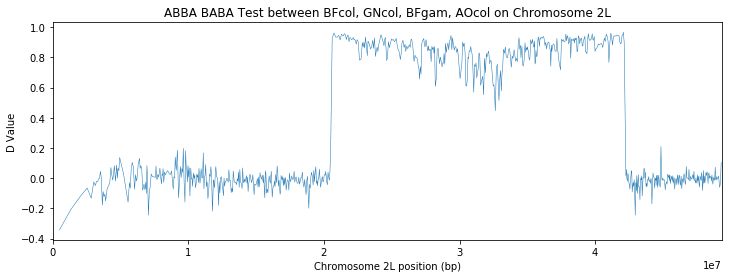

In [6]:
abba_baba('2L', 'BFcol', 'GNcol', 'BFgam', 'AOcol', 10000)

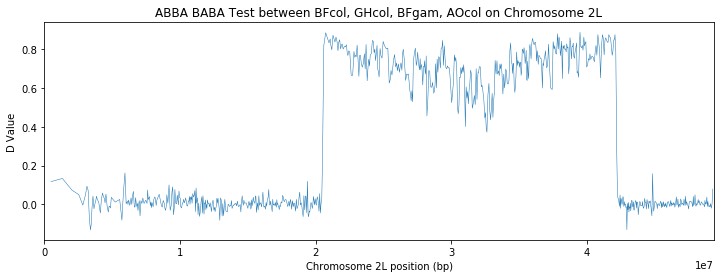

In [7]:
abba_baba('2L', 'BFcol', 'GHcol', 'BFgam', 'AOcol', 10000)

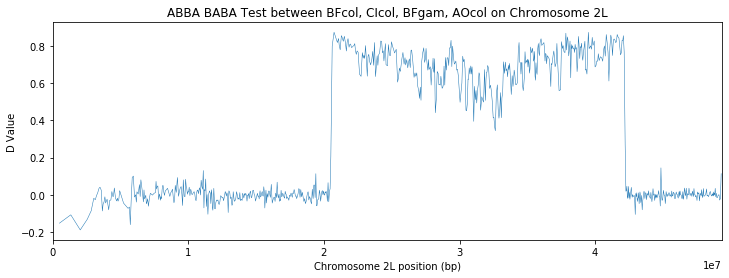

In [8]:
abba_baba('2L', 'BFcol', 'CIcol', 'BFgam', 'AOcol', 10000)